# ECG Classification using ResNet 1D CNN

## Load Required Libraries

In [1]:
%%capture
!pip install wfdb

In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Download the Dataset

Download the data using wfdb if the directory is not present

In [6]:
%%capture
# Set the download path
download_path = 'dataset'

# Create the download folder if it doesn't exist
if not os.path.exists(download_path):
    os.makedirs(download_path)

    # Download the MIT-BIH Arrhythmia Database
    wfdb.dl_database('mitdb', dl_dir=download_path)

## Dataset Loading


In [89]:
# Load the list of record names available in the database
record_names = wfdb.get_record_list("mitdb")

# Create an empty list to store the data frames for each record
data_frames = []

# Iterate over each record and load its data into a DataFrame
for i in range(len(record_names)):
    record_name = record_names[i]
    record_path = f'{download_path}/{record_name}'
    
    # Load the record using the `rdrecord` function
    record = wfdb.rdrecord(record_path, sampfrom=180, sampto=4000,)
    annotation = wfdb.rdann(record_path, 'atr', sampfrom=180, sampto=4000, shift_samps=True)
    
    # Extract the signals from the record and create a DataFrame
    df = pd.DataFrame(data={"Record" : [record], "Annotation" : [annotation],}, index = [i])
    
    # Add the DataFrame to the list
    data_frames.append(df)

# Concatenate all the DataFrames into a single DataFrame
dataset = pd.concat(data_frames, ignore_index=True)

In [109]:
dataset.head()

,Record,Annotation
0,<wfdb.io.record.Record object at 0x7f42202de5f0>,<wfdb.io.annotation.Annotation object at 0x7f4...
1,<wfdb.io.record.Record object at 0x7f421cb30ca0>,<wfdb.io.annotation.Annotation object at 0x7f4...
2,<wfdb.io.record.Record object at 0x7f421cb32bf0>,<wfdb.io.annotation.Annotation object at 0x7f4...
3,<wfdb.io.record.Record object at 0x7f421cb31720>,<wfdb.io.annotation.Annotation object at 0x7f4...
4,<wfdb.io.record.Record object at 0x7f421cb321d0>,<wfdb.io.annotation.Annotation object at 0x7f4...


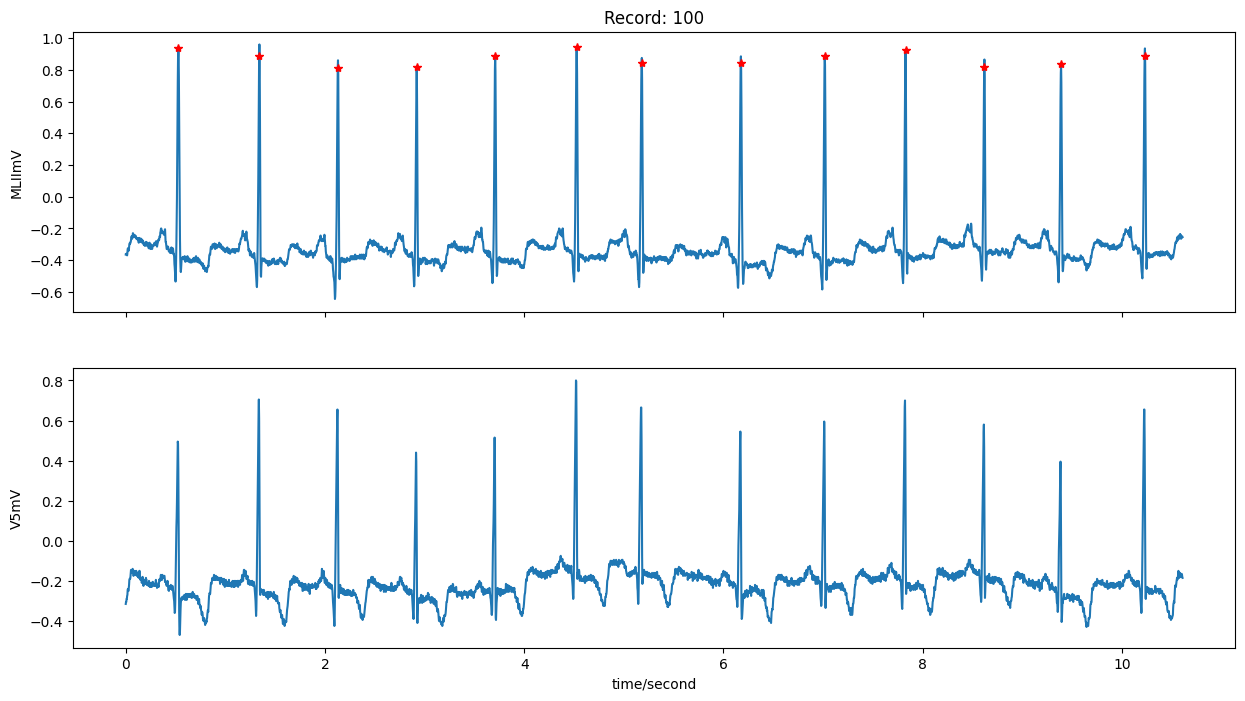

In [110]:
# Check if the loading worked properly by plotting a signal
wfdb.plot_wfdb(record=dataset.iloc[0]["Record"], annotation=dataset.iloc[0]["Annotation"], time_units='seconds',figsize=(15,8))

## Implementing the Pan Tompkins algorithm
Obtained from antimattercorrade via https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection/blob/main/Pan_Tompkins.ipynb

In [111]:
class Pan_Tompkins_QRS():
  
  def band_pass_filter(self,signal,annotation):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed 
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds. 

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''

    # Initialize result
    result = None

    # Create a copy of the input signal
    sig = signal.copy()
	
    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
      sig[index] = signal[index]

      if (index >= 1):
        sig[index] += 2*sig[index-1]

      if (index >= 2):
        sig[index] -= sig[index-2]

      if (index >= 6):
        sig[index] -= 2*signal[index-6]

      if (index >= 12):
        sig[index] += signal[index-12] 
	
    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
      result[index] = -1*sig[index]

      if (index >= 1):
        result[index] -= result[index-1]

      if (index >= 16):
        result[index] += 32*sig[index-16]

      if (index >= 32):
        result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-min(result))
    result = result/max_val

    return result

  def derivative(self,signal,annotation):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The derivative of the input signal is taken to obtain the
    information of the slope of the signal. Thus, the rate of change
    of input is obtain in this step of the algorithm.

    The derivative filter has the recursive equation:
      y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    '''

    # Initialize result
    result = signal.copy()

    # Apply the derivative filter using the equation given
    for index in range(len(signal)):
      result[index] = 0

      if (index >= 1):
        result[index] -= 2*signal[index-1]

      if (index >= 2):
        result[index] -= signal[index-2]

      if (index >= 2 and index <= len(signal)-2):
        result[index] += 2*signal[index+1]

      if (index >= 2 and index <= len(signal)-3):
        result[index] += signal[index+2]

      result[index] = (result[index]*annotation.fs)/8

    return result

  def squaring(self,signal,annotation):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The squaring process is used to intensify the slope of the
    frequency response curve obtained in the derivative step. This
    step helps in restricting false positives which may be caused
    by T waves in the input signal.

    The squaring filter has the recursive equation:
      y(nT) = [x(nT)]^2
    '''

    # Initialize result
    result = signal.copy()

    # Apply the squaring using the equation given
    for index in range(len(signal)):
      result[index] = signal[index]**2

    return result    

  def moving_window_integration(self,signal,annotation):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * annotation.fs)
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
      sum += signal[j]/win_size
      result[j] = sum
    
    # Apply the moving window integration using the equation given
    for index in range(win_size,len(signal)):  
      sum += signal[index]/win_size
      sum -= signal[index-win_size]/win_size
      result[index] = sum

    return result

  def solve(self,signal,annotation):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned. 
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()

    # Bandpass Filter
    global bpass
    bpass = self.band_pass_filter(input_signal.copy(), annotation)

    # Derivative Function
    global der
    der = self.derivative(bpass.copy(), annotation)

    # Squaring Function
    global sqr
    sqr = self.squaring(der.copy(), annotation)

    # Moving Window Integration Function
    global mwin
    mwin = self.moving_window_integration(sqr.copy(), annotation)

    return mwin

In [112]:
# Importing Libraries
from scipy import signal as sg

class heart_rate():

  def __init__(self,signal,samp_freq):
    '''
    Initialize Variables
    :param signal: input signal
    :param samp_freq: sample frequency of input signal
    '''

    # Initialize variables
    self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
    self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

    self.T_wave = False          
    self.m_win = mwin
    self.b_pass = bpass
    self.samp_freq = samp_freq
    self.signal = signal
    self.win_150ms = round(0.15*self.samp_freq)

    self.RR_Low_Limit = 0
    self.RR_High_Limit = 0
    self.RR_Missed_Limit = 0
    self.RR_Average1 = 0


  def approx_peak(self):
    '''
    Approximate peak locations
    '''   

    # FFT convolution
    slopes = sg.fftconvolve(self.m_win, np.full((25,), 1) / 25, mode='same')

    # Finding approximate peak locations
    for i in range(round(0.5*self.samp_freq) + 1,len(slopes)-1):
        if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
            self.peaks.append(i)  


  def adjust_rr_interval(self,ind):
    '''
    Adjust RR Interval and Limits
    :param ind: current index in peaks array
    '''

    # Finding the eight most recent RR intervals
    self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.samp_freq   

    # Calculating RR Averages
    self.RR_Average1 = np.mean(self.RR1)
    RR_Average2 = self.RR_Average1
      
    # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
    if (ind >= 8):
        for i in range(0, 8):
            if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                self.RR2.append(self.RR1[i])

                if (len(self.RR2) > 8):
                    self.RR2.remove(self.RR2[0])
                    RR_Average2 = np.mean(self.RR2)    

    # Adjusting the RR Low Limit and RR High Limit
    if (len(self.RR2) > 7 or ind < 8):
        self.RR_Low_Limit = 0.92 * RR_Average2        
        self.RR_High_Limit = 1.16 * RR_Average2
        self.RR_Missed_Limit = 1.66 * RR_Average2


  def searchback(self,peak_val,RRn,sb_win):
      '''
      Searchback
      :param peak_val: peak location in consideration
      :param RRn: the most recent RR interval
      :param sb_win: searchback window
      '''

      # Check if the most recent RR interval is greater than the RR Missed Limit
      if (RRn > self.RR_Missed_Limit):
          # Initialize a window to searchback  
          win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

          # Find the x locations inside the window having y values greater than Threshold I1             
          coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

          # Find the x location of the max peak value in the search window
          if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      x_max = pos
                      break
          else:
            x_max = None
 
          # If the max peak value is found
          if (x_max is not None):   
            # Update the thresholds corresponding to moving window integration
            self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
            self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
            self.Threshold_I2 = 0.5 * self.Threshold_I1         

            # Initialize a window to searchback 
            win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

            # Find the x locations inside the window having y values greater than Threshold F1                   
            coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      r_max = pos
                      break
            else:
              r_max = None

            # If the max peak value is found
            if (r_max is not None):
              # Update the thresholds corresponding to bandpass filter
              if self.b_pass[r_max] > self.Threshold_F2:                                                        
                  self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                  self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                  self.Threshold_F2 = 0.5 * self.Threshold_F1      

                  # Append the probable R peak location                      
                  self.r_locs.append(r_max)                                                


  def find_t_wave(self,peak_val,RRn,ind,prev_ind):
    '''
    T Wave Identification
    :param peak_val: peak location in consideration
    :param RRn: the most recent RR interval
    :param ind: current index in peaks array
    :param prev_ind: previous index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1): 
        if (ind > 0 and 0.20 < RRn < 0.36):
          # Find the slope of current and last waveform detected        
          curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
          last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
          
          # If current waveform slope is less than half of last waveform slope
          if (curr_slope < 0.5*last_slope):  
              # T Wave is found and update noise threshold                      
              self.T_wave = True                             
              self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

        if (not self.T_wave):
            # T Wave is not found and update signal thresholds
            if (self.probable_peaks[ind] > self.Threshold_F1):   
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

    # Update noise thresholds
    elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def adjust_thresholds(self,peak_val,ind):
    '''
    Adjust Noise and Signal Thresholds During Learning Phase
    :param peak_val: peak location in consideration
    :param ind: current index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1): 
        # Update signal threshold
        self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

        if (self.probable_peaks[ind] > self.Threshold_F1):                                            
            self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

            # Append the probable R peak location
            self.r_locs.append(self.probable_peaks[ind])  

        else:
            # Update noise threshold
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
        
    # Update noise thresholds    
    elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def update_thresholds(self):
    '''
    Update Noise and Signal Thresholds for next iteration
    '''

    self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
    self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
    self.Threshold_I2 = 0.5 * self.Threshold_I1 
    self.Threshold_F2 = 0.5 * self.Threshold_F1
    self.T_wave = False 


  def ecg_searchback(self):
    '''
    Searchback in ECG signal to increase efficiency
    '''

    # Filter the unique R peak locations
    self.r_locs = np.unique(np.array(self.r_locs).astype(int))

    # Initialize a window to searchback
    win_200ms = round(0.2*self.samp_freq)
   
    for r_val in self.r_locs:
        coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

        # Find the x location of the max peak value
        if (len(coord) > 0):
          for pos in coord:
              if (self.signal[pos] == max(self.signal[coord])):
                  x_max = pos
                  break
        else:
          x_max = None

        # Append the peak location
        if (x_max is not None):   
          self.result.append(x_max)


  def find_r_peaks(self):
    '''
    R Peak Detection
    '''

    # Find approximate peak locations
    self.approx_peak()

    # Iterate over possible peak locations
    for ind in range(len(self.peaks)):

        # Initialize the search window for peak detection
        peak_val = self.peaks[ind]
        win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
        max_val = max(self.b_pass[win_300ms], default = 0)

        # Find the x location of the max peak value
        if (max_val != 0):        
          x_coord = np.asarray(self.b_pass == max_val).nonzero()
          self.probable_peaks.append(x_coord[0][0])
        
        if (ind < len(self.probable_peaks) and ind != 0):
            # Adjust RR interval and limits
            self.adjust_rr_interval(ind)
            
            # Adjust thresholds in case of irregular beats
            if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                self.Threshold_I1 /= 2
                self.Threshold_F1 /= 2

            RRn = self.RR1[-1]

            # Searchback
            self.searchback(peak_val,RRn,round(RRn*self.samp_freq))

            # T Wave Identification
            self.find_t_wave(peak_val,RRn,ind,ind-1)

        else:
          # Adjust threholds
          self.adjust_thresholds(peak_val,ind)

        # Update threholds for next iteration
        self.update_thresholds()

    # Searchback in ECG signal 
    self.ecg_searchback()

    return self.result

## Using the Pan Tompkins Algorithm
We follow some of the steps used by antimattercorrade 

In [134]:
QRS_detector = Pan_Tompkins_QRS()

processed_data = []

for row in dataset:
  record = dataset["Record"]
  annotation = dataset["Annotation"]


  ecg = pd.DataFrame(np.array([list(range(len(record[0].adc()))),record[0].adc()[:,0]]).T,columns=['TimeStamp','ecg'])
  output_ecg = QRS_detector.solve(ecg, annotation[0])
  df = pd.DataFrame(data={"Signal" : [ecg], "Annotation" : [annotation]})
  processed_data.append(df)

processed_data = pd.concat(processed_data, ignore_index=True)

In [131]:
processed_data.head()

,Signal,Annotation
0,TimeStamp ecg 0 0 951 1 ...,0 <wfdb.io.annotation.Annotation object at...
1,TimeStamp ecg 0 0 951 1 ...,0 <wfdb.io.annotation.Annotation object at...


Text(0.5, 1.0, 'R Peak Locations')

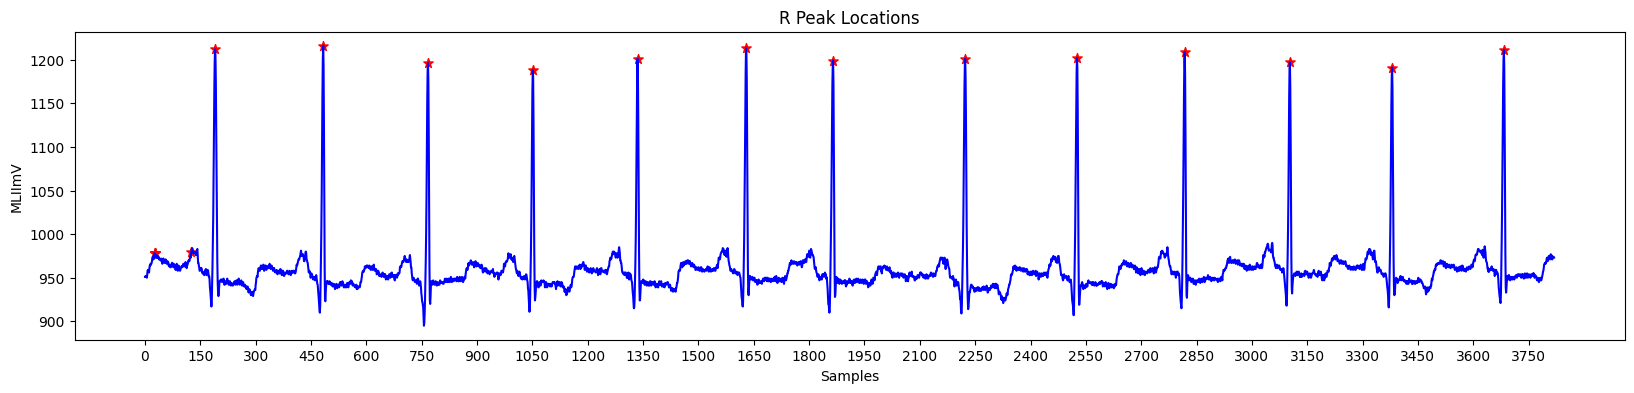

In [117]:
# Plotting function obtained form antimatter comrade
signal = processed_data.iloc[1]["Signal"].iloc[:,1].to_numpy()
hr = heart_rate(signal, processed_data.iloc[0]["Annotation"][0].fs)
result = hr.find_r_peaks()
result = np.array(result)
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(signal)+1, 150))
plt.plot(signal, color = 'blue')      
plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')  
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")